<a href="https://colab.research.google.com/github/martin-fabbri/colab-notebooks/blob/master/product-metrix/customer_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Customer Segmentation

## Cohort Analysis

### Time cohorts

In [0]:
#@title ## Setup
#@markdown * Import dependencies
#@markdown * Download dataset (UCI Online Retail II Data Set)
#@markdown ---
#@markdown **Data Set Information:**
#@markdown This Online Retail II data set contains all the transactions 
#@markdown occurring for a UK-based and registered, non-store online retail 
#@markdown between 01/12/2009 and 09/12/2011.The company mainly sells unique 
#@markdown all-occasion gift-ware. Many customers of the company are wholesalers.

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import warnings

from operator import attrgetter
from datetime import datetime
from datetime import timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx -q


In [0]:
online = pd.read_excel('Online Retail.xlsx', 
                   dtype={'CustomerID': str,  'InvoiceID': str},
                   parse_dates=['InvoiceDate'],
                   infer_datetime_format=True)
online = online.dropna(subset=['CustomerID'])

In [139]:
online.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


* Time cohorts group customers by the time of their first purchase.


In [140]:
get_month = lambda d: datetime(d.year, d.month, 1)  
online['InvoiceMonth'] = online['InvoiceDate'].apply(get_month)
grouping = online.groupby(['CustomerID'])['InvoiceMonth']
online['CohortMonth'] = grouping.transform('min')
online.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth,CohortMonth
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,2010-12-01,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12-01,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,2010-12-01,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12-01,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12-01,2010-12-01


In [0]:
get_date_int = lambda df, column: (df[column].dt.year, df[column].dt.month, df[column].dt.day)

In [142]:
invoice_year, invoice_month, _ = get_date_int(online, 'InvoiceMonth')
cohort_year, cohort_month, _ = get_date_int(online, 'CohortMonth')

years_diff = invoice_year - cohort_year
months_diff = invoice_month - cohort_month

online['CohortIndex'] = years_diff * 12 + months_diff + 1
online['TotalOrder'] = online['UnitPrice'] * online['Quantity']
online.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth,CohortMonth,CohortIndex,TotalOrder
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,2010-12-01,2010-12-01,1,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12-01,2010-12-01,1,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,2010-12-01,2010-12-01,1,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12-01,2010-12-01,1,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12-01,2010-12-01,1,20.34


### Monthly active customers for each cohort

In [143]:
grouping = online.groupby(['CohortMonth', 'CohortIndex'])
cohort_data = grouping['CustomerID'].nunique()
cohort_data = cohort_data.reset_index()
cohort_counts = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='CustomerID')
cohort_counts.head()

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,948.0,362.0,317.0,367.0,341.0,376.0,360.0,336.0,336.0,374.0,354.0,474.0,260.0
2011-01-01,421.0,101.0,119.0,102.0,138.0,126.0,110.0,108.0,131.0,146.0,155.0,63.0,NaN
2011-02-01,380.0,94.0,73.0,106.0,102.0,94.0,97.0,107.0,98.0,119.0,35.0,NaN,NaN
2011-03-01,440.0,84.0,112.0,96.0,102.0,78.0,116.0,105.0,127.0,39.0,NaN,NaN,NaN
2011-04-01,299.0,68.0,66.0,63.0,62.0,71.0,69.0,78.0,25.0,NaN,NaN,NaN,NaN


## Calculate Retention Rate

In [144]:
cohort_sizes = cohort_counts.iloc[:,0]
retention = cohort_counts.divide(cohort_sizes, axis=0)
retention.round(3) * 100

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,100.0,38.2,33.4,38.7,36.0,39.7,38.0,35.4,35.4,39.5,37.3,50.0,27.4
2011-01-01,100.0,24.0,28.3,24.2,32.8,29.9,26.1,25.7,31.1,34.7,36.8,15.0,NaN
2011-02-01,100.0,24.7,19.2,27.9,26.8,24.7,25.5,28.2,25.8,31.3,9.2,NaN,NaN
2011-03-01,100.0,19.1,25.5,21.8,23.2,17.7,26.4,23.9,28.9,8.9,NaN,NaN,NaN
2011-04-01,100.0,22.7,22.1,21.1,20.7,23.7,23.1,26.1,8.4,NaN,NaN,NaN,NaN
2011-05-01,100.0,23.7,17.2,17.2,21.5,24.4,26.5,10.4,NaN,NaN,NaN,NaN,NaN
2011-06-01,100.0,20.9,18.7,27.2,24.7,33.6,10.2,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,100.0,20.9,20.4,23.0,27.2,11.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,100.0,25.1,25.1,25.1,13.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Monthly Average Quantity Sold

In [145]:
grouping = online.groupby(['CohortMonth', 'CohortIndex'])
cohort_data = grouping['Quantity'].mean()
cohort_data = cohort_data.reset_index()
average_quantity = cohort_data.pivot(index='CohortMonth', 
                                     columns='CohortIndex', 
                                     values='Quantity')
average_quantity.round(1)

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,11.0,14.6,15.0,14.8,12.9,14.3,15.2,14.8,16.7,16.7,17.3,12.8,14.8
2011-01-01,10.0,12.6,12.3,10.9,12.2,14.9,14.2,14.4,11.4,9.9,9.1,9.5,NaN
2011-02-01,10.8,12.1,18.6,12.0,11.1,11.4,13.3,12.4,10.3,11.9,12.6,NaN,NaN
2011-03-01,9.8,9.9,12.2,9.5,13.6,12.3,13.2,12.2,10.5,8.9,NaN,NaN,NaN
2011-04-01,9.8,10.1,9.4,11.6,11.5,8.2,9.7,9.3,7.3,NaN,NaN,NaN,NaN
2011-05-01,10.9,9.0,13.9,11.8,10.9,8.7,10.1,7.4,NaN,NaN,NaN,NaN,NaN
2011-06-01,10.3,13.7,10.5,13.3,10.2,9.8,9.3,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,9.7,12.7,7.1,7.8,6.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,9.9,6.0,5.3,6.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Cohort Retention Heatmap

In [146]:
retention.round(3) * 100

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,100.0,38.2,33.4,38.7,36.0,39.7,38.0,35.4,35.4,39.5,37.3,50.0,27.4
2011-01-01,100.0,24.0,28.3,24.2,32.8,29.9,26.1,25.7,31.1,34.7,36.8,15.0,NaN
2011-02-01,100.0,24.7,19.2,27.9,26.8,24.7,25.5,28.2,25.8,31.3,9.2,NaN,NaN
2011-03-01,100.0,19.1,25.5,21.8,23.2,17.7,26.4,23.9,28.9,8.9,NaN,NaN,NaN
2011-04-01,100.0,22.7,22.1,21.1,20.7,23.7,23.1,26.1,8.4,NaN,NaN,NaN,NaN
2011-05-01,100.0,23.7,17.2,17.2,21.5,24.4,26.5,10.4,NaN,NaN,NaN,NaN,NaN
2011-06-01,100.0,20.9,18.7,27.2,24.7,33.6,10.2,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,100.0,20.9,20.4,23.0,27.2,11.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,100.0,25.1,25.1,25.1,13.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


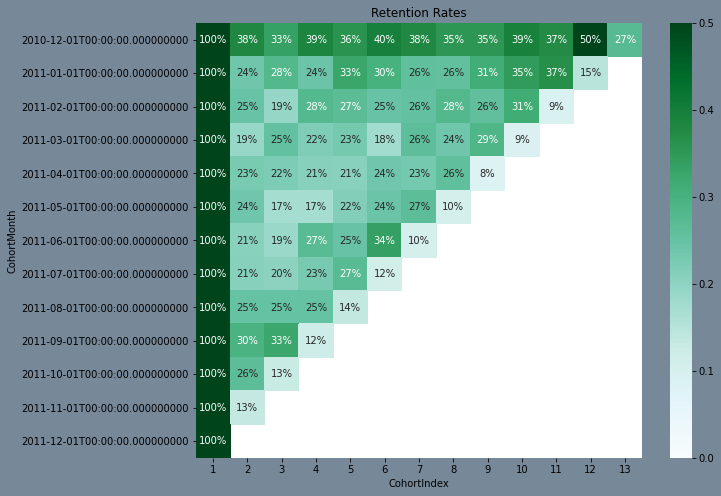

In [147]:
plt.figure(figsize=(10, 8), facecolor='lightslategray')
plt.title('Retention Rates')
sns.heatmap(data=retention,
            annot=True,
            fmt='.0%',
            vmin=0.0,
            vmax=0.5,
            cmap='BuGn');

## Recency, Frequency, Monetary (RFM) segmentation



In [0]:
spend = np.random.rand(8) * 1000
data = {
    'CustomerID' : [id for id in range(8)],
    'Spend' : spend.tolist()
}

In [0]:
df_spend = pd.DataFrame(data=data)

In [150]:
spend_quartile = pd.qcut(df_spend['Spend'], q=4, labels=range(1, 5))
df_spend['Spend_Quartile'] = spend_quartile
print(df_spend.sort_values('Spend'))

   CustomerID       Spend Spend_Quartile
5           5   15.195357              1
4           4   19.429158              1
6           6  172.408360              2
2           2  313.058372              2
3           3  736.437734              3
0           0  779.785167              3
7           7  859.143073              4
1           1  992.711469              4


In [151]:
recency_days = np.random.randint(0, 400, 8)
recency = {
    'CustomerID' : [id for id in range(8)],
    'Recency_Days' : recency_days.tolist()
}
df_recency = pd.DataFrame(data=recency)
df_recency.head()

,CustomerID,Recency_Days
0,0,75
1,1,28
2,2,179
3,3,62
4,4,119


In [152]:
r_labels = list(range(4, 0, -1))
recency_quartiles = pd.qcut(df_recency['Recency_Days'], q=4, labels=r_labels)
df_recency['Recency_Quatile'] = recency_quartiles
df_recency.sort_values('Recency_Days')

,CustomerID,Recency_Days,Recency_Quatile
5,5,15,4
1,1,28,4
3,3,62,3
0,0,75,3
6,6,78,2
4,4,119,2
2,2,179,1
7,7,372,1


## Data preparation steps

In [153]:
f'Min: {min(online.InvoiceDate)}, Max: {max(online.InvoiceDate)}'

'Min: 2010-12-01 08:26:00, Max: 2011-12-09 12:50:00'

In [154]:
snapshot_date = max(online.InvoiceDate) + timedelta(days=1)
snapshot_date

Timestamp('2011-12-10 12:50:00')

In [0]:
datamart = online.groupby(['CustomerID']).agg({
  'InvoiceDate' : lambda x: (snapshot_date - x.max()).days,
  'InvoiceNo': 'count',
  'TotalOrder' : 'sum'
})
datamart = datamart.rename(columns={
    'InvoiceDate' : 'Recency',
    'InvoiceNo' : 'Frequency',
    'TotalOrder' : 'MonetaryValue'
})

In [156]:
datamart.loc['12346']

Recency          326.0
Frequency          2.0
MonetaryValue      0.0
Name: 12346, dtype: float64

In [157]:
online[online['CustomerID'] == '12346']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth,CohortMonth,CohortIndex,TotalOrder
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom,2011-01-01,2011-01-01,1,77183.6
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346,United Kingdom,2011-01-01,2011-01-01,1,-77183.6


## Build RFM segments

In [158]:
r_labels = range(4, 0, -1)
f_labels = range(1, 5)
m_labels = range(1, 5)

datamart['R'] = pd.qcut(datamart['Recency'], 4, labels=r_labels)
datamart['F'] = pd.qcut(datamart['Frequency'], 4, labels=f_labels)
datamart['M'] = pd.qcut(datamart['MonetaryValue'], 4, labels=m_labels)

datamart.head(5)


,Recency,Frequency,MonetaryValue,R,F,M
CustomerID,,,,,,
12346,326,2,0.00,1,1,1
12347,2,182,4310.00,4,4,4
12348,75,31,1797.24,2,2,4
12349,19,73,1757.55,3,3,4
12350,310,17,334.40,1,1,2


In [0]:
rfm_segment = lambda d: f'{d.R}{d.F}{d.M}'
datamart['RFM_Segment'] = datamart.apply(rfm_segment, axis=1)
datamart['RFM_Score'] = datamart[['R', 'F', 'M']].sum(axis=1) 

In [160]:
datamart

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment,RFM_Score
CustomerID,,,,,,,,
12346,326,2,0.00,1,1,1,111,3.0
12347,2,182,4310.00,4,4,4,444,12.0
12348,75,31,1797.24,2,2,4,224,8.0
12349,19,73,1757.55,3,3,4,334,10.0
12350,310,17,334.40,1,1,2,112,4.0
...,...,...,...,...,...,...,...,...
18280,278,10,180.60,1,1,1,111,3.0
18281,181,7,80.82,1,1,1,111,3.0
18282,8,13,176.60,4,1,1,411,6.0


### Find average value for RFM Score segment

What is the average MonetaryValue for the segment with RFM_Score of 9 (nine)?

In [161]:
datamart[datamart.RFM_Score == 9]['MonetaryValue'].mean()

1369.558009732361

In [162]:
def rfm_level(df): 
  rfm_score = df['RFM_Score']
  if rfm_score < 6:
    return 'Low'
  elif rfm_score < 10:
    return 'Middle'
  else:
    return 'Top'

datamart['RFM_Level'] = datamart.apply(rfm_level, axis=1)
datamart.head(5)

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment,RFM_Score,RFM_Level
CustomerID,,,,,,,,,
12346,326,2,0.00,1,1,1,111,3.0,Low
12347,2,182,4310.00,4,4,4,444,12.0,Top
12348,75,31,1797.24,2,2,4,224,8.0,Middle
12349,19,73,1757.55,3,3,4,334,10.0,Top
12350,310,17,334.40,1,1,2,112,4.0,Low


### Summay metrics per RFM score

In [163]:
datamart.groupby('RFM_Score').agg({
    'Recency' : 'mean',
    'Frequency' : 'mean',
    'MonetaryValue' : ['mean', 'count']
}).round(1)

Recency Frequency MonetaryValue      
             mean      mean          mean count
RFM_Score                                      
3.0         264.8       7.8         109.1   392
4.0         174.5      13.9         227.1   391
5.0         153.0      21.2         346.8   517
6.0          94.3      28.5         491.8   468
7.0          78.8      39.7         724.2   447
8.0          62.7      57.0         974.7   467
9.0          44.2      79.0        1369.6   411
10.0         31.3     115.3        1894.0   440
11.0         20.5     193.9        3845.7   368
12.0          6.7     371.8        8850.7   471

## Grouping into named segments

In [164]:
def segment_me(df):
  rfm_score = df['RFM_Score'] 
  if rfm_score < 5:
    return 'Bronze'
  elif rfm_score < 9:
    return 'Silver'
  return 'Gold'

datamart['General_Segment'] = datamart.apply(segment_me, axis=1)
datamart

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment,RFM_Score,RFM_Level,General_Segment
CustomerID,,,,,,,,,,
12346,326,2,0.00,1,1,1,111,3.0,Low,Bronze
12347,2,182,4310.00,4,4,4,444,12.0,Top,Gold
12348,75,31,1797.24,2,2,4,224,8.0,Middle,Silver
12349,19,73,1757.55,3,3,4,334,10.0,Top,Gold
12350,310,17,334.40,1,1,2,112,4.0,Low,Bronze
...,...,...,...,...,...,...,...,...,...,...
18280,278,10,180.60,1,1,1,111,3.0,Low,Bronze
18281,181,7,80.82,1,1,1,111,3.0,Low,Bronze
18282,8,13,176.60,4,1,1,411,6.0,Middle,Silver


In [165]:
datamart.groupby(['General_Segment']).agg({
    'Recency' : 'mean',
    'Frequency' : 'mean',
    'MonetaryValue' : ['mean', 'count']
}).round(1)

Recency Frequency MonetaryValue      
                   mean      mean          mean count
General_Segment                                      
Bronze            219.7      10.9         168.0   783
Gold               25.2     195.1        4130.3  1690
Silver             98.9      36.1         625.8  1899

## Clustering Segments

### Skewed variables

In [166]:
datamart.describe()

,Recency,Frequency,MonetaryValue,RFM_Score
count,4372.000000,4372.000000,4372.000000,4372.000000
mean,92.047118,93.053294,1898.459701,7.501601
std,100.765435,232.471608,8219.345141,2.828144
min,1.000000,1.000000,-4287.630000,3.000000
25%,17.000000,17.000000,293.362500,5.000000
50%,50.000000,42.000000,648.075000,7.000000
75%,143.000000,102.000000,1611.725000,10.000000
max,374.000000,7983.000000,279489.020000,12.000000


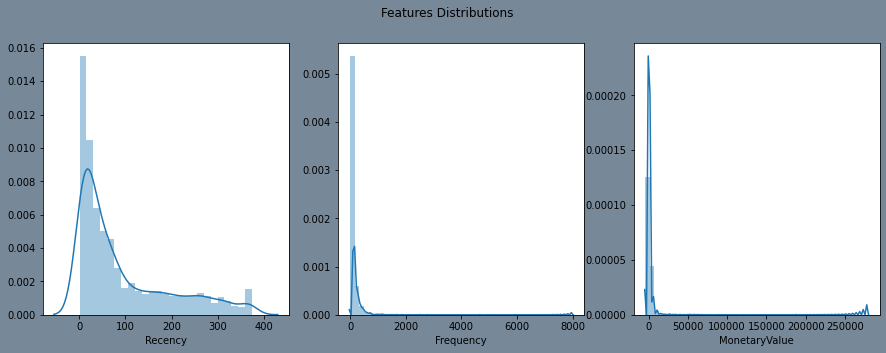

In [167]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, facecolor='lightslategray', figsize=(15, 5))
fig.suptitle('Features Distributions')
sns.distplot(datamart['Recency'], ax=ax1)
sns.distplot(datamart['Frequency'], ax=ax2)
sns.distplot(datamart['MonetaryValue'], ax=ax3);

## Managing skewed variables

* Logarithmic transformation (positive values only)


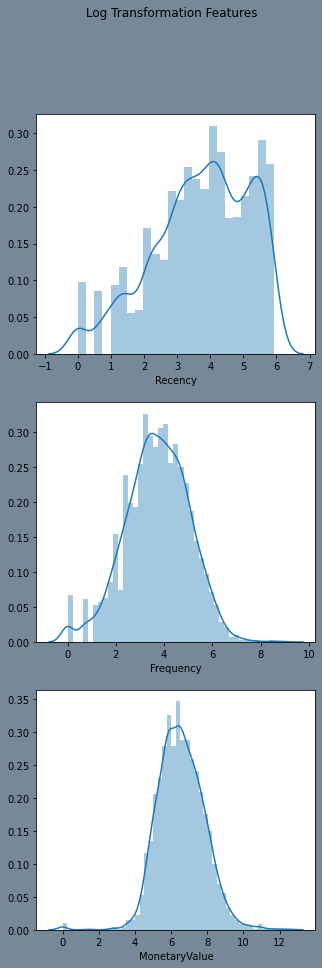

In [168]:
# preprocessing remove negative values before applying log transformation
datamart_clean = datamart[datamart['MonetaryValue'] >=0 ]
log_xform = {
  'Recency': np.log(datamart_clean['Recency']),
  'Frequency': np.log(datamart_clean['Frequency']),
  'MonetaryValue': np.log(datamart_clean['MonetaryValue'] + 1),
}

datamart_log_xform = pd.DataFrame(log_xform)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, facecolor='lightslategray', figsize=(5, 15))
fig.suptitle('Log Transformation Features');

sns.distplot(datamart_log_xform['Recency'], ax=ax1)
sns.distplot(datamart_log_xform['Frequency'], ax=ax2)
sns.distplot(datamart_log_xform['MonetaryValue'], ax=ax3);

In [169]:
datamart_log_xform.describe()

,Recency,Frequency,MonetaryValue
count,4329.000000,4329.000000,4329.000000
mean,3.716194,3.710179,6.554497
std,1.460423,1.316899,1.289325
min,0.000000,0.000000,0.000000
25%,2.833213,2.890372,5.710526
50%,3.912023,3.737670,6.488718
75%,4.927254,4.624973,7.393392
max,5.924256,8.985070,12.540722


In [170]:
scaler = StandardScaler()
scaler.fit(datamart_log_xform)
datamart_normalized = scaler.transform(datamart_log_xform)
print('mean:', datamart_normalized.mean(axis=0).round(2))
print('std:', datamart_normalized.std(axis=0).round(2))

mean: [-0. -0.  0.]
std: [1. 1. 1.]


In [0]:
datamart_normalized = pd.DataFrame(
    data=datamart_normalized, 
    index=datamart_log_xform.index, 
    columns=datamart_log_xform.columns)

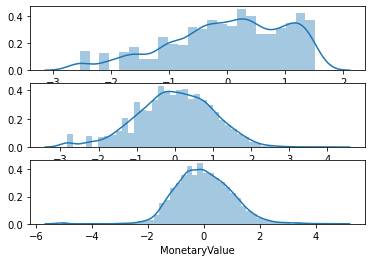

In [172]:
# Plot recency distribution
plt.subplot(3, 1, 1); sns.distplot(datamart_normalized['Recency'])

# Plot frequency distribution
plt.subplot(3, 1, 2); sns.distplot(datamart_normalized['Frequency'])

# Plot monetary value distribution
plt.subplot(3, 1, 3); sns.distplot(datamart_normalized['MonetaryValue']);

## K-means clustering segmentation

In [173]:
kmeans = KMeans(n_clusters=3, random_state=1)
kmeans.fit(datamart_normalized)
cluster_labels = kmeans.labels_
cluster_labels

array([0, 2, 1, ..., 0, 2, 1], dtype=int32)

In [174]:
datamart_rfm_k3 = datamart_clean.assign(Cluster = cluster_labels)
datamart_rfm_k3

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment,RFM_Score,RFM_Level,General_Segment,Cluster
CustomerID,,,,,,,,,,,
12346,326,2,0.00,1,1,1,111,3.0,Low,Bronze,0
12347,2,182,4310.00,4,4,4,444,12.0,Top,Gold,2
12348,75,31,1797.24,2,2,4,224,8.0,Middle,Silver,1
12349,19,73,1757.55,3,3,4,334,10.0,Top,Gold,1
12350,310,17,334.40,1,1,2,112,4.0,Low,Bronze,0
...,...,...,...,...,...,...,...,...,...,...,...
18280,278,10,180.60,1,1,1,111,3.0,Low,Bronze,0
18281,181,7,80.82,1,1,1,111,3.0,Low,Bronze,0
18282,8,13,176.60,4,1,1,411,6.0,Middle,Silver,0


In [175]:
grouped = datamart_rfm_k3.groupby(['Cluster'])
grouped.agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count']
}).round(1)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0         168.9      15.2         279.8  1501
1          68.3      67.0        1071.8  1841
2          12.1     263.8        5998.1   987

In [0]:
sse = {}
for k in range(1, 21):
  kmeans = KMeans(n_clusters=k, random_state=1)
  kmeans.fit(datamart_normalized)
  sse[k] = kmeans.inertia_


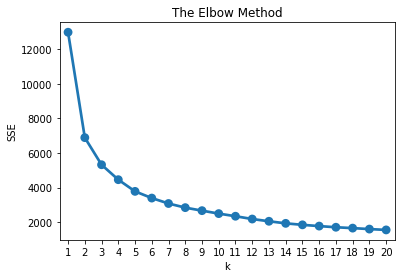

In [178]:
plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()));

## Profile and interpret segments

In [180]:
datamart_normalized

,Recency,Frequency,MonetaryValue
CustomerID,,,
12346,1.418043,-2.291277,-5.084254
12347,-2.070219,1.134483,1.407433
12348,0.411774,-0.209753,0.729200
12349,-0.528507,0.440692,0.711887
12350,1.383580,-0.666009,-0.573369
...,...,...,...
18280,1.308969,-1.068994,-1.049268
18281,1.015100,-1.339870,-1.667713
18282,-1.120868,-0.869742,-1.066545


In [182]:
datamart_melt = pd.melt(
  datamart_rfm_k3.reset_index(), 
  id_vars=['CustomerID', 'Cluster'],
  value_vars=['Recency', 'Frequency', 'MonetaryValue'], 
  var_name='Metric', 
  value_name='Value'
)
datamart_melt

,CustomerID,Cluster,Metric,Value
0,12346,0,Recency,326.00
1,12347,2,Recency,2.00
2,12348,1,Recency,75.00
3,12349,1,Recency,19.00
4,12350,0,Recency,310.00
...,...,...,...,...
12982,18280,0,MonetaryValue,180.60
12983,18281,0,MonetaryValue,80.82
12984,18282,0,MonetaryValue,176.60
12985,18283,2,MonetaryValue,2094.88


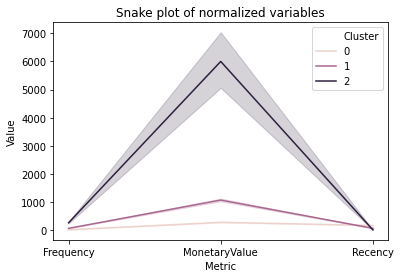

In [183]:
# Add the plot title
plt.title('Snake plot of normalized variables')

# Add the x axis label
plt.xlabel('Metric')

# Add the y axis label
plt.ylabel('Value')

# Plot a line for each value of the cluster variable
sns.lineplot(data=datamart_melt, x='Metric', y='Value', hue='Cluster')
plt.show()

In [184]:
datamart_rfm_k3

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment,RFM_Score,RFM_Level,General_Segment,Cluster
CustomerID,,,,,,,,,,,
12346,326,2,0.00,1,1,1,111,3.0,Low,Bronze,0
12347,2,182,4310.00,4,4,4,444,12.0,Top,Gold,2
12348,75,31,1797.24,2,2,4,224,8.0,Middle,Silver,1
12349,19,73,1757.55,3,3,4,334,10.0,Top,Gold,1
12350,310,17,334.40,1,1,2,112,4.0,Low,Bronze,0
...,...,...,...,...,...,...,...,...,...,...,...
18280,278,10,180.60,1,1,1,111,3.0,Low,Bronze,0
18281,181,7,80.82,1,1,1,111,3.0,Low,Bronze,0
18282,8,13,176.60,4,1,1,411,6.0,Middle,Silver,0


In [187]:
# Calculate average RFM values for each cluster
cluster_avg = datamart_rfm_k3.groupby(['Cluster']).mean() 

# Calculate average RFM values for the total customer population
population_avg = datamart_rfm_k3.mean()

# Calculate relative importance of cluster's attribute value compared to population
relative_imp = cluster_avg / population_avg - 1

# Print relative importance scores rounded to 2 decimals
print(relative_imp.round(2))

         Cluster   F  Frequency   M  ...   R  RFM_Score  RFM_Segment  Recency
Cluster                              ...                                     
0            NaN NaN      -0.84 NaN  ... NaN      -0.41          NaN     0.87
1            NaN NaN      -0.29 NaN  ... NaN       0.07          NaN    -0.24
2            NaN NaN       1.81 NaN  ... NaN       0.49          NaN    -0.87

[3 rows x 9 columns]


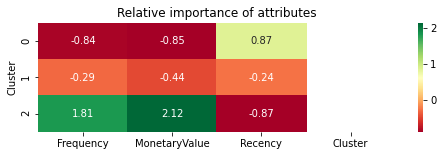

In [192]:
plt.figure(figsize=(8, 2))
plt.title('Relative importance of attributes')
sns.heatmap(data=relative_imp[['Frequency', 'MonetaryValue', 'Recency', 'Cluster']], annot=True, fmt='.2f', cmap='RdYlGn');